In [21]:
# Imports needed
from math import sin, cos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # for plotting

from probDE.utils.utils import root_gen
from probDE.Kalman.kalman_multi_solver import kalman_multi_solver

In [24]:
# RHS of ODE
def ode_fun(x_t, t):
    return sin(2*t) - x_t[0]

# LHS vector of ODE
w_mat = np.array([[0.0, 0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
q = 2 # ODE order
p = q+2 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [L,U].
N = 100 # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
L = 0
U = 10 

# Now we need the parameters for the solver
# First we need to generate roots, rho, for the CAR(p) prior
# We suggest using root_gen to parametrize them as desribed: rho_k = -exp(k/tau)
tau = 50 # decorrelation parameter
roots = root_gen(tau, p)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
mu = np.zeros(p)

# Initial value, x0, for the IVP
a = np.array([[-1.0, 0.0, 1.0]])

rootlst = [roots]*n
sigmalst = [.5]*n

In [25]:
Xn, _,_ = kalman_multi_solver(ode_fun, L, U, N, mu, sigmalst, rootlst, w_mat, a)

In [27]:
# Exact Solution for x_t^{(0)}
def ode_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

# Exact Solution for x_t^{(1)}
def ode_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

# Get exact solutions for x^{(0)}, x^{(1)}
tseq = np.linspace(L, U, N)
exact_x = np.zeros(N)
exact_x1 = np.zeros(N)
for t in range(N):
    exact_x[t] = ode_exact_x(tseq[t])
    exact_x1[t] = ode_exact_x1(tseq[t])
exact = np.array(list(zip(exact_x, exact_x1)))

In [28]:
tauseq = np.linspace(100, 200, 9)
sigmaseq = np.linspace(0.001, 0.5, 9)

def recon_err(fun, L, U, N, mu, w_mat, a, tauseq, sigmaseq, exact, n, p):
    std = np.zeros((2, len(tauseq), len(sigmaseq)))
    tseq = np.linspace(L, U, N)
    for i, tau in enumerate(tauseq):
        for j, sigma in enumerate(sigmaseq):
            roots = root_gen(tau, p)
            rootlst = [roots]*n
            sigmalst = [sigma]*n
            try:
                Xn, _,_ = kalman_multi_solver(ode_fun, L, U, N, mu, sigmalst, rootlst, w_mat, a)
                std[:, i, j]= np.std(exact - Xn[:, [0,1]], axis=0)
            except:
                std[:, i, j] = np.nan
            
    return std
rec_err = recon_err(ode_fun, L, U, N, mu, w_mat, a, tauseq, sigmaseq, exact, n, p)

In [33]:
rec_err.shape

(2, 9, 9)

In [29]:
rec_err_1 = pd.DataFrame(rec_err[0], index=tauseq, columns=sigmaseq)
rec_err_2 = pd.DataFrame(rec_err[0], index=tauseq, columns=sigmaseq)

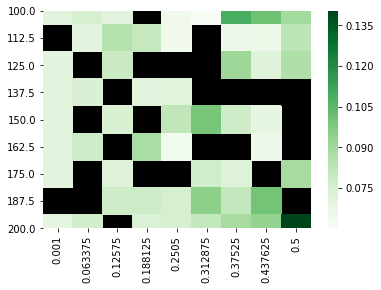

In [31]:
axs = sns.heatmap(rec_err_1, cmap="Greens", mask=np.isnan(rec_err[0]))
axs.set_facecolor('black')